Import all packages

In [78]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.linear_model import (LinearRegression, Ridge,Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from pybrain.utilities import percentError
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.datasets.classification import ClassificationDataSet
from pybrain.tools.validation import Validator
from sklearn.metrics import confusion_matrix
import pymc3 as pm, theano.tensor as tt

Create a helper function which converts the non-numeric labels into discreet value integers (numeric values) using the sklearn LabelEncoder function.

In [79]:
def labelConversion(df):
# Discreet value integer encoder
    label_encoder = preprocessing.LabelEncoder()
    df['drugname'] = label_encoder.fit_transform(df['drugname'])
    df['route'] = label_encoder.fit_transform(df['route'])
    df['dose_unit'] = label_encoder.fit_transform(df['dose_unit'])
    df['dose_form'] = label_encoder.fit_transform(df['dose_form'])
    df['dose_freq'] = label_encoder.fit_transform(df['dose_freq'])
    df['mfr_sndr'] = label_encoder.fit_transform(df['mfr_sndr'])
    df['pt'] = label_encoder.fit_transform(df['pt'])
    df['outc_cod'] = label_encoder.fit_transform(df['outc_cod'])
    df['dose_amt'] = label_encoder.fit_transform(df['dose_amt'])
    return df    
    

In [80]:
#Helper function to create the data frame by reading from the csv file
def createDataFrame(str):
    perf_df = pd.read_csv(str ,sep=",",skipinitialspace=True,error_bad_lines=False, index_col=False, dtype='unicode')
    return perf_df  


Now let us create the data frames.

We take 80% of the data from training and 20% of the data for test

In [81]:
#Creating DataFrame
print("Creating Test Dataframe...")
main_df= createDataFrame("MergedFile.csv")
print("Creating Training and Test Dataframe...")


train_df=main_df.sample(frac=0.8,random_state=200)
test_df =main_df.drop(train_df.index)

Creating Test Dataframe...
Creating Training and Test Dataframe...


Now let us set the input parameters for the Neural Network

In [82]:
#Setting the input parameter for Neural Network
print("#Setting the input parameter for Neural Network...")
cols_to_keep=['drugname','route','dose_amt','dose_unit','dose_form','dose_freq','mfr_sndr','pt']

#Setting the input parameter for Neural Network...


In [83]:
print("Checking all required columns in train and test dataframes")
train_num_df=labelConversion(train_df)
test_num_df= labelConversion(test_df)

Checking all required columns in train and test dataframes


Now we create the X and y variables for the Train and Test Dataframes by filtering the dataframes with the significant columns

In [84]:
print("Creating X and y variables for Train and Test Dataframes")
train_num_df_X = train_num_df[cols_to_keep]
outcome_num_train_y = train_num_df['outc_cod']

test_num_df_X = test_num_df[cols_to_keep]
outcome_num_test_y = test_num_df['outc_cod']

Creating X and y variables for Train and Test Dataframes


Let us check the distribution of some of the fields from the dataset using MLE

# MLE (Maximum likelihood estimation)

![mle](https://user-images.githubusercontent.com/25159589/43870011-6f769c82-9b43-11e8-9380-7bc59fe000ae.gif)

In [55]:
new_cols_to_keep=['drugname','route','dose_amt','dose_unit','dose_form','dose_freq','mfr_sndr','pt','outc_cod']
mle_data_df = labelConversion(main_df)
mle_data_df = mle_data_df [new_cols_to_keep]

In [56]:
mle_data_df['outc_cod'].unique()

array([3, 1, 5, 4, 2, 0, 6], dtype=int64)

Text(0.5,1,'Normal distribution for drugName')

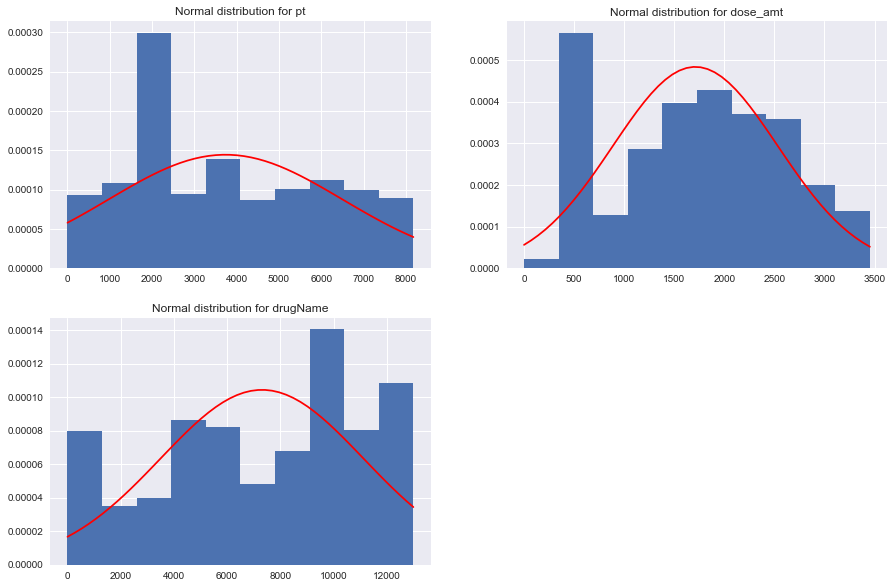

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set(color_codes=True)

fig=plt.figure(figsize=(15,10))
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)


x1=np.linspace(0,mle_data_df.pt.max())
x2=np.linspace(0,mle_data_df.dose_amt.max())
x3=np.linspace(0,mle_data_df.drugname.max())

ax1.hist(mle_data_df.pt,bins=10,normed=True)
ag,bg=stats.norm.fit(mle_data_df.pt)
ax1.plot(x1,stats.norm.pdf(x1,ag,bg/0.8),color='red')
ax1.set_title("Normal distribution for pt")


ax2.hist(mle_data_df.dose_amt,bins=10,normed=True)
ag,bg=stats.norm.fit(mle_data_df.dose_amt)
ax2.plot(x2,stats.norm.pdf(x2,ag,bg),color='red')
ax2.set_title("Normal distribution for dose_amt")

ax3.hist(mle_data_df.drugname,bins=10,normed=True)
ag,bg=stats.norm.fit(mle_data_df.drugname)
ax3.plot(x3,stats.norm.pdf(x3,ag,bg),color='red')
ax3.set_title("Normal distribution for drugName")

# Conclusion:
- After applying MLE we can see that the three columns that we have applied MLE to follow normal distribution
- We can say that these columns are related to each other and can be used for making classification
- The drug amount column follows the perfect normal distribution and hence we can see that we can use MCMC sampler to sample that columns data point 

In [58]:
dose_amt = mle_data_df.dose_amt
dose_amt.head()

0    1953
1    1742
2    1742
3    1953
4    3184
Name: dose_amt, dtype: int64

Now let us check the correlations between the data

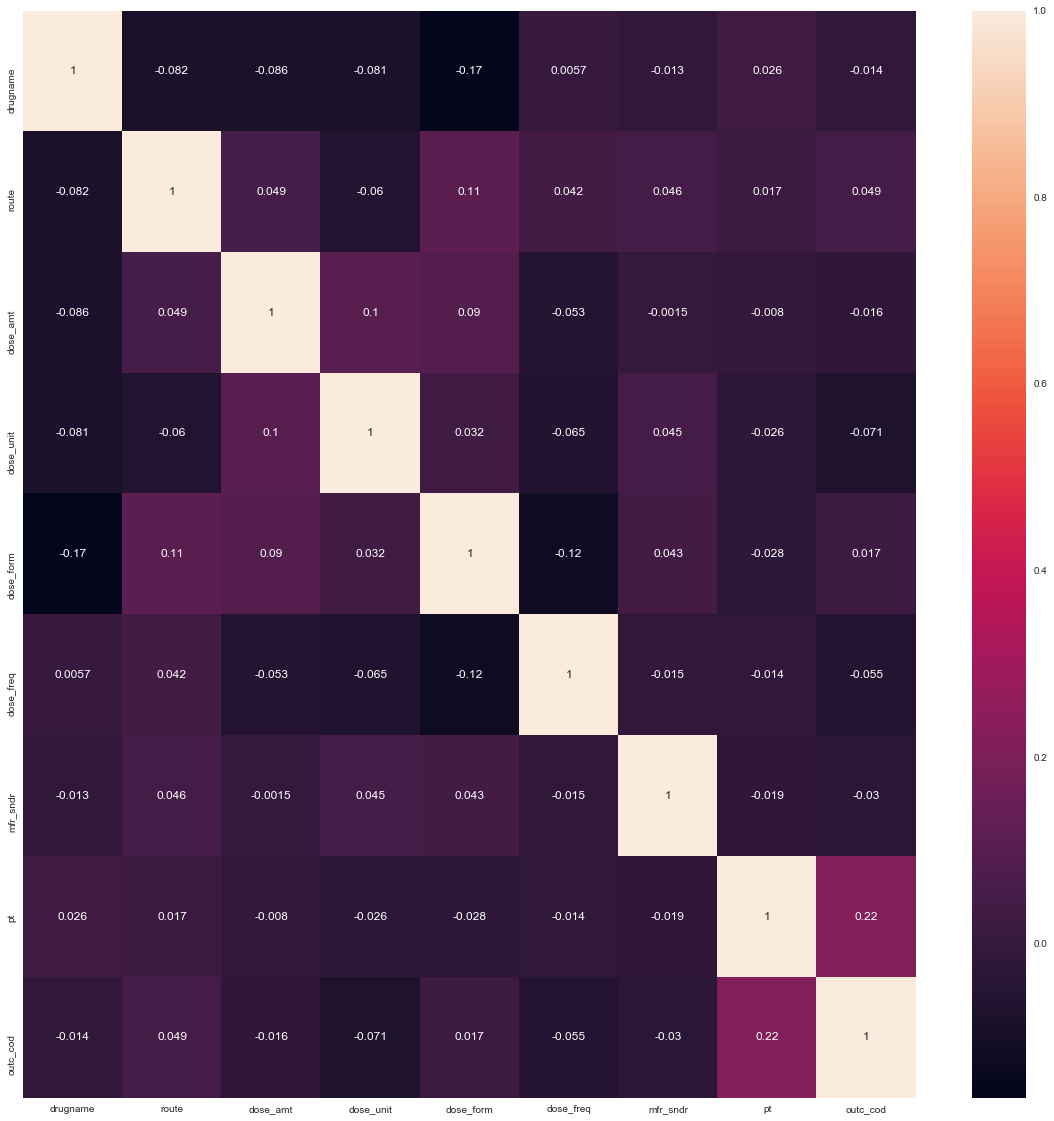

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
corr1 = mle_data_df.corr()
corr1
sns.heatmap(corr1,annot=True)

# Conclusion(on correlation plot):
- As we can see we have plotted the correlation of columns which we have found in our EDA 
- The above columns are only non-null columns in dataset 
- Rest of the columns had more that 50% data null in that column so we can jot fill values in that column
- Also all these columns are in categorical values so first we had to convert all the values in numerical format
- After plotting the graph we can say that these columns are not correlated as we would like them to be for prediction
- Hence we will not get great accuracy as we dont have correlated data.
- Only few columns like pt show better correlation with our taget column which is outc_cod. 

In [60]:
mle_data_df.head()

,drugname,route,dose_amt,dose_unit,dose_form,dose_freq,mfr_sndr,pt,outc_cod
0,935,27,1953,66,197,6,202,6467,3
1,5822,70,1742,34,254,50,202,4461,1
2,4492,27,1742,34,114,19,202,3625,1
3,935,27,1953,66,197,6,202,168,3
4,7511,104,3184,34,174,19,202,3262,5


Now that we are done with the basics, let us use some classification algorithms on our data set

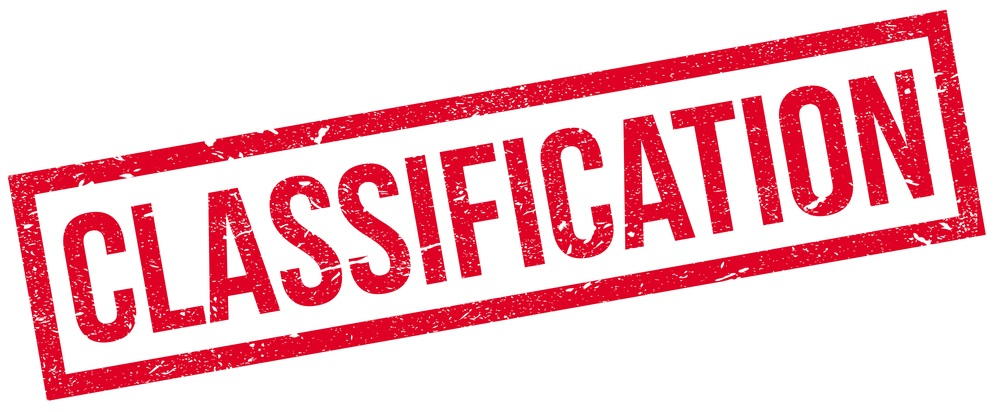

# Classification

## 1. Neural Networks


![neural network](https://user-images.githubusercontent.com/25159589/43870055-a425ba8a-9b43-11e8-89f5-61d95b605e2c.jpeg)



We then create helper functions which would build the neural network.

Our neural network has 10 inputs, 5 hidden layers and 2 classes

In [61]:
# build a neural network
def build_neural_network(train_num_df_X, train_y, test_num_df_X, test_y ):
 
    #Calculating rows and columns for input dfs
    trn_rows,trn_cols=train_num_df_X.shape
    tst_rows,tst_cols=test_num_df_X.shape
       
    # build train dataset
    print("Inside build_neural_network : ")
    print("Building train dataset")
    train_data = ClassificationDataSet(trn_cols, 1 , nb_classes=7)
    for k in range(len(train_num_df_X)): 
        train_data.addSample(train_num_df_X.iloc[k],train_y.iloc[k]) 
    
    # build test dataset
    print("Building test dataset")
    test_data = ClassificationDataSet(tst_cols, 1 , nb_classes=7)
    for k in range(len(test_num_df_X)): 
        test_data.addSample(test_num_df_X.iloc[k],test_y.iloc[k])
        
    print("Train Dataset input length: {}".format(len(train_data['input'])))
    print("Train Dataset input|output dimensions are {}|{}".format(train_data.indim, train_data.outdim))
     
    print("Train Data length: {}".format(len(train_data)))
    print("Test Data length: {}".format(len(test_data)))
 
    # encode with one output neuron per class
    train_data._convertToOneOfMany()
    test_data._convertToOneOfMany()
 
    print("Train Data input|output dimensions are {}|{}".format(train_data.indim, train_data.outdim))
    print("Test Data input|output dimensions are {}|{}".format(test_data.indim, test_data.outdim))
 
    # build network (INPUT=10,HIDDEN=5,CLASSES=2,outclass=SoftmaxLayer)
    print("Building Neural network with 5 hidden layer")
    network = buildNetwork(train_data.indim,100,train_data.outdim,outclass=SoftmaxLayer)
 
    # train network
    print("Training the network, it may take a while(20-30 min)...")
    trainer = BackpropTrainer(network,dataset=train_data,momentum=0.1,verbose=True,weightdecay=0.01)
    trainer.trainOnDataset(train_data, 10) 
    
    #training model on One epoch
    print("Total epochs: {}".format(trainer.totalepochs))
 
    # test network
    print("Predicting the output array with the trained model")
    output = network.activateOnDataset(test_data).argmax(axis=1)
     
    #Neural network Percent error and accuracy    
    print("Percent error: {}".format(percentError(output, test_data['class'])))
    accuracy=Validator.classificationPerformance(output, test_y)
    print("Model Accuracy: {}".format(accuracy))
    print("Classification report for Test data %s:\n%s\n"% (network, metrics.classification_report(test_y, output)))
    
    #Compute confusion metrics
    cm = confusion_matrix(test_y,output)
    print(cm)

In [45]:
#Calling Neural Network
print("Calling neural network with train and test dataframes")
build_neural_network(train_num_df_X, outcome_num_train_y, test_num_df_X, outcome_num_test_y)

Calling neural network with train and test dataframes
Inside build_neural_network : 
Building train dataset
Building test dataset
Train Dataset input length: 352334
Train Dataset input|output dimensions are 8|1
Train Data length: 352334
Test Data length: 88083
Train Data input|output dimensions are 8|7
Test Data input|output dimensions are 8|7
Building Neural network with 5 hidden layer
Training the network, it may take a while(20-30 min)...
Total error:  0.0506805677935
Total error:  0.0503353268485
Total error:  0.0506952119937
Total error:  0.0504056312381
Total error:  0.0504687345801
Total error:  0.0502874090202
Total error:  0.0503192255023
Total error:  0.0505188292043
Total error:  0.0504822892209
Total error:  0.0502349537658
Total epochs: 10
Predicting the output array with the trained model
Percent error: 56.577319119466864
Model Accuracy: 0.4342268088053313


C:\Courses\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification report for Test data FeedForwardNetwork-8
   Modules:
    [<BiasUnit 'bias'>, <LinearLayer 'in'>, <SigmoidLayer 'hidden0'>, <SoftmaxLayer 'out'>]
   Connections:
    [<FullConnection 'FullConnection-4': 'in' -> 'hidden0'>, <FullConnection 'FullConnection-5': 'bias' -> 'out'>, <FullConnection 'FullConnection-6': 'bias' -> 'hidden0'>, <FullConnection 'FullConnection-7': 'hidden0' -> 'out'>]
:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        59
          1       0.00      0.00      0.00     17550
          2       0.00      0.00      0.00       939
          3       0.00      0.00      0.00     30083
          4       0.00      0.00      0.00      1116
          5       0.43      1.00      0.61     38248
          6       0.00      0.00      0.00        88

avg / total       0.19      0.43      0.26     88083


[[    0     0     0     0     0    59     0]
 [    0     0     0     0     0 17550     0]
 [    0     0     0 

## 2. Decision Tree

![decision tree](https://user-images.githubusercontent.com/25159589/43870095-db65f870-9b43-11e8-87df-5989da782395.jpg)

In [62]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(train_num_df_X, outcome_num_train_y)
dtree_predictions = dtree_model.predict(test_num_df_X)
accuracy = dtree_model.score(test_num_df_X, outcome_num_test_y)
cm = confusion_matrix(outcome_num_test_y, dtree_predictions)
print(accuracy)
print(cm)

0.4136666553137382
[[    0     0     0    13     0    46     0]
 [    0     0     0   966     0 16584     0]
 [    0     2     0   249     0   688     0]
 [    0    23     0  7342     0 22718     0]
 [    0     0     0   182     0   934     0]
 [    0    21     0  9132     0 29095     0]
 [    0     0     0     2     0    86     0]]


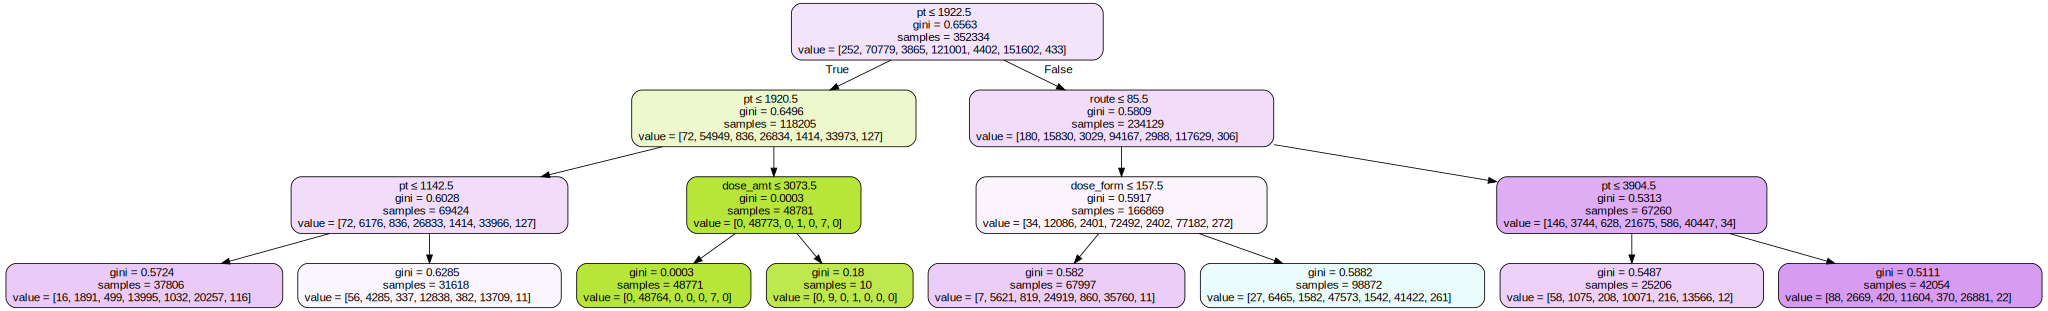

In [63]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(dtree_model, out_file=None, 
                         feature_names=train_num_df_X.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph

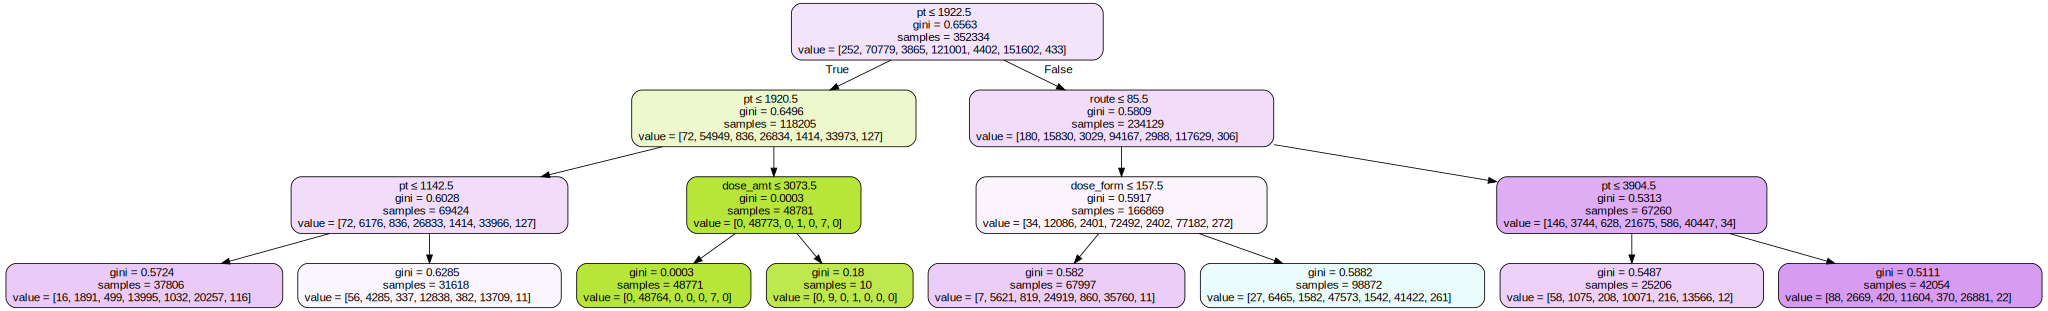

In [64]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(dtree_model, out_file=None, 
                         feature_names=train_num_df_X.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Exporting the tree to pdf:

In [65]:
graph = graphviz.Source(dot_data) 
graph.render("outc_cod") 

'outc_cod.pdf'

## Conclusion for Decision Tree:
- First we tried to classify our data we used Decision Tree Classifier
- This algorithm divides your data parallely 
- Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
- Decision trees decompose the attribute space into P disjoint subsets, Kr, r = 1, ... P, using decision rules (cuts) that are usually orthogonal to the attribute axes (axis parallel). Thus a decision rule can be described by a simple expression of the form ai � Ti, or ai < Ti, where Ti is some threshold, making their operation easy to comprehend by the user. Figure 4 shows part of a decision tree along with the rules that occur at each node. Given labelled attribute data, decision trees choose the most appropriate attributes with which to partition the feature space to give the best classification performance

## 3. KNN (k-nearest neighbors algorithm) 

<img width="639" alt="knn" src="https://user-images.githubusercontent.com/25159589/43870122-f8942bf6-9b43-11e8-883a-9fcc21ec4042.png">




Now lets try and apply KNN on our dataset and see if we get better results: 
- KNN can be used for both classification and regression predictive problems. KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations  (x,y)  and would like to capture the relationship between  x  and  y . More formally, our goal is to learn a function  h:X→Y  so that given an unseen observation  x ,  h(x)  can confidently predict the corresponding output  y .

- STEP 1: Choose the number K of neighbors

- STEP 2: Take the K nearest neighbors of the new data point, according to your distance metric

- STEP 3: Among these K neighbors, count the number of data points to each category

- STEP 4: Assign the new data point to the category where you counted the most neighbors

In [66]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 15).fit(train_num_df_X, outcome_num_train_y)
 
# accuracy on X_test
accuracy = knn.score(test_num_df_X, outcome_num_test_y)
print (accuracy)
 
# creating a confusion matrix
knn_predictions = knn.predict(test_num_df_X) 
cm = confusion_matrix(outcome_num_test_y, knn_predictions)
print(cm)

0.40799019106978646
[[    0     2     0    22     2    33     0]
 [    0  3464     6  4858     7  9215     0]
 [    0    76     4   344     1   514     0]
 [    2  3166    25 10847    17 16026     0]
 [    0    66     3   392     3   652     0]
 [    3  3627    47 12937    15 21619     0]
 [    0     4     0    38     0    46     0]]


## Conclusion for KNN Algorithm:
- We more or like get same accuracy when we appy KNN algorithm.
- As we can see confusion matrix there are lot of false positives 

## 4. Gaussian Naive Bayes¶


![gaussian naive](https://user-images.githubusercontent.com/25159589/43870132-0aec379e-9b44-11e8-9551-1346c593b850.png)

- implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). The distribution is parametrized by vectors \theta_y = (\theta_{y1},\ldots,\theta_{yn}) for each class y, where n is the number of features (in text classification, the size of the vocabulary) and \theta_{yi} is the probability P(x_i \mid y) of feature i appearing in a sample belonging to class y.
- Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of independence between every pair of features. Given a class variable y and a dependent feature vector x_1 through x_n, Bayes’ theorem states the following relationship:

- P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots x_n \mid y)}
                                 {P(x_1, \dots, x_n)}

In [105]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(train_num_df_X, outcome_num_train_y)
gnb_predictions = gnb.predict(test_num_df_X)
 
#print(gnb_predictions)
# accuracy on X_test
print ('accuracy')
accuracy = gnb.score(test_num_df_X,outcome_num_test_y)
print (accuracy)
 
# creating a confusion matrix
cm = confusion_matrix(outcome_num_test_y, gnb_predictions)
print('confusion matrix:  \n')
print(cm)

from sklearn import metrics
print('\n')
print('Report: \n')
print(metrics.classification_report(outcome_num_test_y, gnb_predictions))

accuracy
0.4408909778277307
confusion matrix:  

[[    0     1     0     5     0    53     0]
 [    0  1059     0  1707     0 14784     0]
 [    0    19     0   227     0   693     0]
 [    0   735     0  5491     0 23857     0]
 [    0    28     0   265     0   823     0]
 [    0  1047     0  4916     0 32285     0]
 [    0     1     0    13     0    74     0]]


Report: 



C:\Courses\Python\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        59
          1       0.37      0.06      0.10     17550
          2       0.00      0.00      0.00       939
          3       0.43      0.18      0.26     30083
          4       0.00      0.00      0.00      1116
          5       0.44      0.84      0.58     38248
          6       0.00      0.00      0.00        88

avg / total       0.41      0.44      0.36     88083



In [106]:
gnb

GaussianNB(priors=None)

## Conclusion for Naive Bayes:

- Bayes therom gives us most correct and better results so far
- It has least number of false positives 
- Still we can say that accuracy is not improved 
- Now we can pin point the reason after applying 3 algorithms that we dont have enough correlated data to get more correct accuracy
- We may have to find more features to get correct results. 

## 5. Logistic Regression

In [109]:
from sklearn import linear_model
from sklearn import metrics

lr = linear_model.LogisticRegression()
lr.fit(train_num_df_X, outcome_num_train_y)

print ("Logistic regression Train Accuracy :: ", metrics.accuracy_score(outcome_num_train_y, lr.predict(train_num_df_X)))
print ("Logistic regression Test Accuracy :: ", metrics.accuracy_score(outcome_num_test_y, lr.predict(test_num_df_X)))
 

Logistic regression Train Accuracy ::  0.4288998507098378
Logistic regression Test Accuracy ::  0.43451063201752893


In [95]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
import matplotlib.pyplot as plt

n_classes = 7

# classifier
clf = OneVsRestClassifier(linear_model.LogisticRegression())
y_score = clf.fit(train_num_df_X, outcome_num_train_y).decision_function(test_num_df_X)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    A=np.array(outcome_num_test_y)==i
    A=A.astype(int)
    fpr[i], tpr[i], _ = roc_curve(A, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
# for i in range(n_classes):
#     plt.figure()
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()


In [91]:
outcome_num_test_y.head()

0     3
2     1
8     5
9     5
13    1
Name: outc_cod, dtype: int64

In [98]:
outcome_num_train_y.head()

186616    3
24425     1
185793    1
19962     3
130570    5
Name: outc_cod, dtype: int64

In [93]:
clf

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [25]:
cm = confusion_matrix(outcome_num_test_y, lr.predict(test_num_df_X))
print(cm)

[[    0     7     0     1     0    51     0]
 [    0  3526     0  2418     0 11606     0]
 [    0    87     0   157     0   695     0]
 [    0  3409     0  4370     0 22304     0]
 [    0   203     0   141     0   772     0]
 [    0  4396     0  3475     0 30377     0]
 [    0    22     0     4     0    62     0]]


Now let us try Multinomial Logistic regression:

In [27]:
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(train_num_df_X, outcome_num_train_y)
print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(outcome_num_train_y, mul_lr.predict(train_num_df_X)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(outcome_num_test_y, mul_lr.predict(test_num_df_X)))
cm = confusion_matrix(outcome_num_test_y, mul_lr.predict(test_num_df_X))
print(cm)

Multinomial Logistic regression Train Accuracy ::  0.42727355293556685
Multinomial Logistic regression Test Accuracy ::  0.43646333571744833
[[    0     2     0     4     0    53     0]
 [    0   368     0  6216     0 10966     0]
 [    0    18     0   334     0   587     0]
 [    0   980     0 10942     0 18161     0]
 [    0    55     0   408     0   653     0]
 [    0  1029     0 10084     0 27135     0]
 [    0     8     0    28     0    52     0]]


C:\Courses\Python\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


## Conclusion of Logistic Regression:

- As we see in graphs above they show the result of Logistic regression classifier
- Each ROC curve is indicative of the perticular class being predited.
- We have 7 classes to predict so we will see 7 curves
- Conclusion is for Class 1 and class 2 we see better results and rest of the classes the curve went flat.
- This is happening because our data is biased in terms of Class OT hence we see better curve.
- As our data is not correlated well hence we see results not much accurate

## 6. Random Forest

![forest](https://user-images.githubusercontent.com/25159589/43873595-20f45c9a-9b55-11e8-8c49-0a0c514643cf.jpg)

In [100]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)
y_rf = rf.fit(train_num_df_X, outcome_num_train_y)


y_train_estimated = rf.predict(train_num_df_X)
y_test_estimated = rf.predict(test_num_df_X)

     
conf_mat_logred = metrics.confusion_matrix(y_test_estimated,outcome_num_test_y)
print(conf_mat_logred)

[[    0     0     0     0     0     0     0]
 [    0   227     5   102     1    97     0]
 [    0     0     0     0     0     0     0]
 [   24  8041   374 13690   506 16351    50]
 [    0     0     0     0     0     0     0]
 [   35  9282   560 16291   609 21800    38]
 [    0     0     0     0     0     0     0]]


In [111]:
print ("Random Forest Train Accuracy :: ", metrics.accuracy_score(outcome_num_train_y, rf.predict(train_num_df_X)))
print ("Random Forest Test Accuracy :: ", metrics.accuracy_score(outcome_num_test_y, rf.predict(test_num_df_X)))

Random Forest Train Accuracy ::  0.9508931865786441
Random Forest Test Accuracy ::  0.4172995924298673
